In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [64]:
def fill_rec(mat, choices, choice_id, player_id):
    if player_id < 0 or choice_id < 0:
        return
    idx = [player_id] + choices
    if sum(choices) % player_id == 0:
        mat[*idx] = 1
    else:
        mat[*idx] = -0.5
    choices[choice_id] -= 1
    fill_rec(mat, choices, choice_id - 1, player_id)
    choices[choice_id] += 1
    fill_rec(mat, choices, choice_id, player_id - 1)
    mat[player_id]

In [92]:
T = 100000
n_choices = 2
n_players = 2
eta = 0.01
epsilon = 0.5
mixed = True
update_method = 'ftrl'

if n_players == 2:
    M_row = np.array([[1,-1], [-1, 1]])
    M_col = np.array([[-1,1], [1, -1]])
elif n_players == 3:
    mat = np.zeros([n_players] + [n_choices] * n_players)
    fill_rec(mat, n_players, n_choices)
    for i in range(n_players):
        for j in range(n_choices):
            for k in range(n_choices):
                if i + j + k % 3 == i:
                    mat[i, j, k] = 1
                else:
                    mat[i, j, k] = -0.5
    

In [85]:
def get_utility(strategies):
    reward = np.zeros(n_players)
    reward_vector = np.zeros((n_players, n_choices))
    if n_players == 2:
        reward[0] = strategies[0] @ M_row @ strategies[1].T
        reward[1] = strategies[1] @ M_col @ strategies[0].T
        
        reward_vector[0] = M_row @ strategies[1].T
        reward_vector[1] = M_col @ strategies[0].T
    if n_players == 3:
        pass
    return reward, reward_vector

In [86]:
def update(U, u, t, i):
    if update_method == 'ftrl':
        U[i] = U[i] + u[t][i]
    elif update_method == 'oftrl':
        if t >= 1:
            U[i] = U[i] + 2*u[t][i] - u[t-1][i]
        else:
            U[i] = U[i] + u[t][i]

In [87]:
def run(eta):
    probs = np.zeros((n_players, T, n_choices), dtype=float)
    total_rewards = [0] * n_players
    x = np.full((n_players, n_choices), 1/n_choices, dtype=float)
    x[0] = [0.3, 0.7]
    x[1] = [0.7, 0.3]
    
    s = np.zeros((n_players, n_choices))
    regret = np.zeros((n_players, T))
    U = np.zeros((n_players, n_choices))
    u = np.zeros((T, n_players, n_choices))
    sum_u = np.zeros((n_players, n_choices))
    for t in range(T):
        for i in range(n_players):
            if not mixed:
                strat = np.random.choice(np.arange(n_choices), p=x[i])
                s[i] = np.zeros(n_choices)
                s[i][strat] = 1
            else:
                s[i] = x[i]
        
        cur_rewards, u[t] = get_utility(s)
        sum_u += u[t]
        for i in range(n_players):
            total_rewards[i] += cur_rewards[i]
            update(U, u, t, i)
            x[i] = np.exp(eta * U[i])
            x[i] /= x[i].sum()
            probs[i, t] = x[i].copy()
        for i in range(n_players):
            best_in_hind = np.argmax(sum_u[i], axis=0)
            regret[i, t] = sum_u[i][best_in_hind] - total_rewards[i]
    return regret, probs

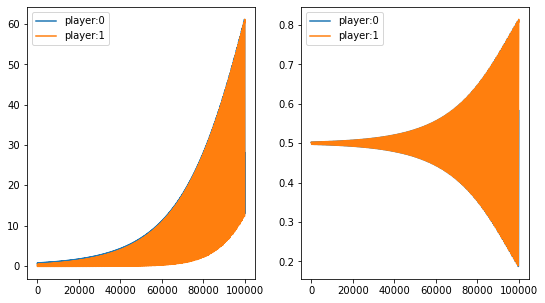

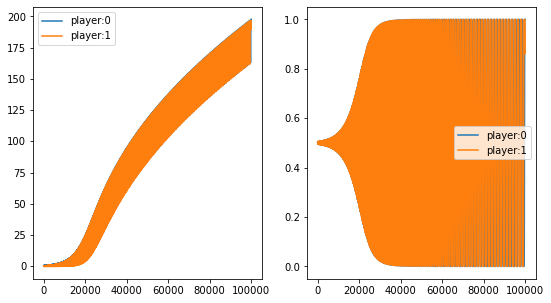

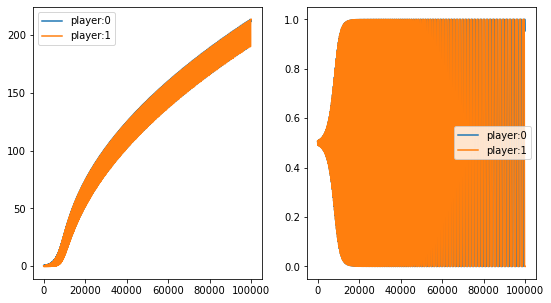

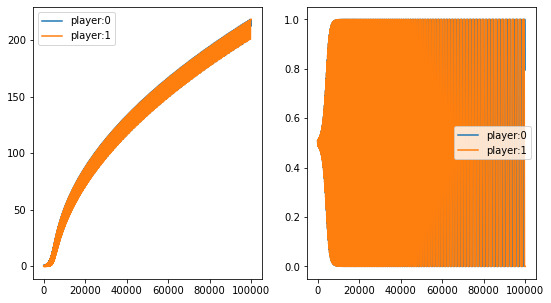

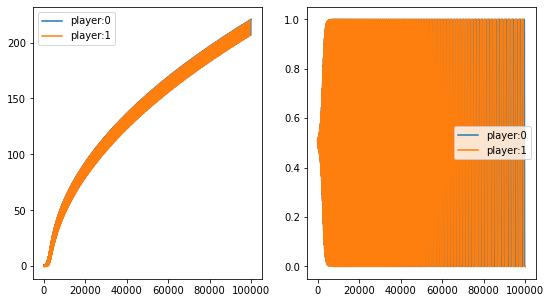

In [93]:
for eta in [0.01, 0.02, 0.03, 0.04, 0.05]:
    regret, probs = run(eta)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5))
    legends = []
    for i in range(n_players):
        ax1.plot(np.arange(T), regret[i], label=f'player:{i}')
        ax1.legend()
        legends = f'player:{i}'
        ax2.plot(np.arange(T), probs[i, :, 0], label=legends)
        ax2.legend()
    plt.show()